# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---


---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project.
![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

### Import necessary libraries, modules and classes

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob

import requests

from PIL import Image
import cv2

In [2]:
import functools
import operator

In [3]:
import torch

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [4]:
#from torchvision import datasets
#import torchvision.transforms as transforms
from torchvision import datasets, transforms as T

import torchvision.models as models



In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # OSError: image file is truncated (150 bytes not processed)

In [6]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [20]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

In [9]:
def detect_face_box(ix):
    """Get index of the file in human folder."""
    # load color (BGR) image
    if isinstance(ix, int):
        img = cv2.imread(human_files[ix])
    elif isinstance(ix, str): # ix is the file path
        img = cv2.imread(ix)
        
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

Number of faces detected: 24


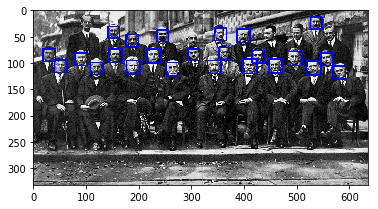

In [10]:
file_path = '/home/workspace/dog_project/images/solvay_conferences_5th_1927.jpg'
detect_face_box(file_path)

Number of faces detected: 2


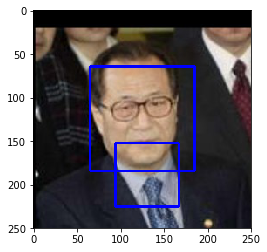

In [11]:
detect_face_box(8)

Number of faces detected: 2


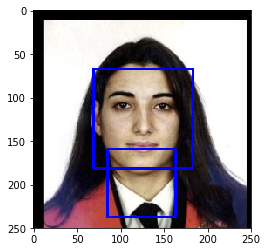

In [12]:
detect_face_box(756)

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [11]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [14]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

has_human_humans = round(np.mean([face_detector(im) for im in human_files_short]), 2) * 100
has_human_dogs = round(np.mean([face_detector(im) for im in dog_files_short]), 2) * 100

In [15]:
print(f'In the first 100 human images, in {has_human_humans}% of them a human image is detected.')
print(f'\nIn the first 100 dog images, in {has_human_dogs}% of them a human image is detected.')

In the first 100 human images, in 98.0% of them a human image is detected.

In the first 100 dog images, in 17.0% of them a human image is detected.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [16]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [12]:
# define VGG16 model
VGG16 = models.vgg16(pretrained= True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:07<00:00, 72652872.01it/s]


In [18]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# # move model to GPU if CUDA is available
# if use_cuda:
#     VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [13]:
def VGG16_predict(img_path, label = False):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        eg: 'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'
        
    Returns:
        Class Index corresponding to VGG-16 model's prediction
        (0, 999) inclusive
        
        if label is True: returns the string as well
    '''
    if img_path[-3:] != 'jpg':
        raise Exception('Make sure your image is in "jpg" format!')
        
    # Load the image
    img = Image.open(img_path)
    
    # Define a pre-processing pipeline for the image
    transform_pipeline = T.Compose([
        T.CenterCrop(224),
        T.ToTensor()
    ])
    
    data = transform_pipeline(img)
    
    # Prep the model for evaluation phase.
    ##prevents any randomness in the prediction, by killing dropout for example.
    VGG16.eval()
    pred = VGG16(data.unsqueeze(0).cpu()).argmax().item()
    
    if label:
        LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'

        # Get the class labels.
        # Make an HTTP GET request and store the response.
        response = requests.get(LABELS_URL)
        labels = {int(key): value for key, value in response.json().items()}
        return pred, labels[pred]
    
    return pred

In [20]:
img_path = 'images/Curly-coated_retriever_03896.jpg'

VGG16_predict(img_path, label = True)

(267, 'standard poodle')

In [21]:
def get_vgg16_prediction(img_path):
    im = Image.open(img_path)
    ix, label = VGG16_predict(img_path, label = True)
    print(f'VGG16 classifies this image as:\n\t{label}.')
    plt.imshow(im)

VGG16 classifies this image as:
	standard poodle.


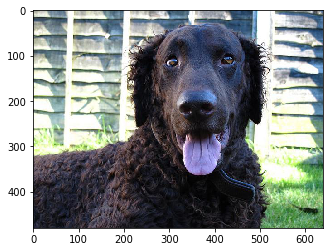

In [22]:
get_vgg16_prediction('images/Curly-coated_retriever_03896.jpg')

VGG16 classifies this image as:
	Welsh springer spaniel.


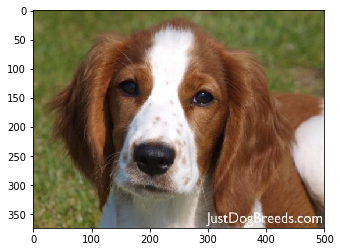

In [23]:
get_vgg16_prediction('images/Welsh_springer_spaniel_08203.jpg')

VGG16 classifies this image as:
	teddy, teddy bear.


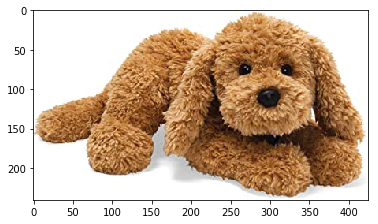

In [24]:
get_vgg16_prediction('images/stuffed_dog1.jpg')

VGG16 classifies this image as:
	dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk.


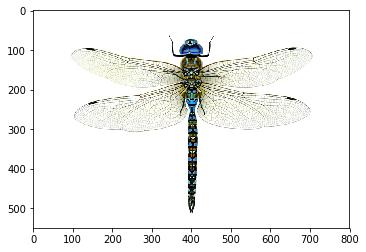

In [25]:
get_vgg16_prediction('images/blue-eyed_darner_small_01.jpg')

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [14]:
def dog_detector(img_path):
    """returns True if a dog is detected in the image
    img_path {str}
    """
    ix = VGG16_predict(img_path, label = False)
    # Categories corresponding to dogs are (151, 268) inclusive
    if 151 <= ix <= 268:
        return True
    return False

In [27]:
dog_detector('images/Curly-coated_retriever_03896.jpg')

True

In [28]:
dog_detector('images/Welsh_springer_spaniel_08203.jpg')

True

In [29]:
dog_detector('images/stuffed_dog1.jpg')

False

In [30]:
dog_detector('images/blue-eyed_darner_small_01.jpg')

False

### Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [31]:
has_dog_humans = round(np.mean([dog_detector(im) for im in human_files_short]), 2) * 100
has_dog_dogs = round(np.mean([dog_detector(im) for im in dog_files_short]), 2) * 100

print(f'In the first 100 human images, in {has_dog_humans}% of them a dog is detected.')
print(f'\nIn the first 100 dog images, in {has_dog_dogs}% of them a dog is detected.')

In the first 100 human images, in 0.0% of them a dog is detected.

In the first 100 dog images, in 59.0% of them a dog is detected.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [32]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [33]:
dir_images = '/data/dog_images/'

dir_train = os.path.join(dir_images, 'train')
dir_valid = os.path.join(dir_images, 'valid')
dir_test = os.path.join(dir_images, 'test')

# Note: to prevent "TypeError: tensor is not a torch image."
# The ToTensor transform should come before the Normalize transform
transform_dogs = {
    'train': T.Compose([
        T.RandomResizedCrop(224),
        T.RandomRotation(15),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean= [.5] * 3, std= [.25] * 3),
    ]),
    
    'eval': T.Compose([
        # Note: argument to size should be a tuple.
        # Otherwise: RuntimeError: invalid argument 0
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize(mean= [.5] * 3, std= [.25] * 3),
    ])
}


data_train = datasets.ImageFolder(dir_train, transform= transform_dogs['train'])
data_valid = datasets.ImageFolder(dir_valid, transform= transform_dogs['eval'])
data_test = datasets.ImageFolder(dir_test, transform= transform_dogs['eval'])

params_other = {'batch_size': 32, 'num_workers': 0, 'shuffle': True}

loader_train = torch.utils.data.DataLoader(data_train, **params_other)
loader_valid = torch.utils.data.DataLoader(data_valid, **params_other)
loader_test = torch.utils.data.DataLoader(data_test, **params_other)

# Make the loaders a dictionary for convenient usage in the coming functions
loaders_scratch = {'train': loader_train, 'valid': loader_valid, 'test': loader_test}

In [34]:
# @TODO show a sample image from loader

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: My choice of image processing comes from VGG16 algorithm, for example the input size and the normalization; although, for normalization I simply rounded and used same number for all 3 channels, for both mean and standard deviation.    
   
First I ran my algorithm like so, and then to improve performance I also added rotation and horizontal flip. With a little modification in learning rate and network architecture, I already achieved 15% accuracy on test set. With 10% being the acceptable result, I don't pursue the tuning further.    

Naturally, augmentation could be a viable option if higher degrees of accuracy is of interest.

### Model Architecture

In [35]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self, in_channels, n_classes, input_dim):
        """
        Input dim for Dog Breed.
        
        Arguments:
        in_classes {int} number of channels for images
        n_classes {int} number of output classes/categories
        input_dim {tuple} the shape of image
        """
        nn.Module.__init__(self)
        # convolutional layer
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding= 1),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size= 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size= 2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size= 2)
        )
        
        num_features_before_fcnn = functools.reduce(
            operator.mul,
            list(self.feature_extractor(torch.rand(1, *input_dim)).shape)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features= num_features_before_fcnn, out_features= 256),
            nn.Dropout(inplace= True),
            
            nn.Linear(in_features= 256, out_features= 128),
            nn.Dropout(inplace= True),
            
            nn.Linear(in_features= 128, out_features= n_classes)
        )
    
    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        # flatten the vector
        out = out.view(batch_size, -1)
        out = self.classifier(out)
        return out

In [36]:
# instantiate the CNN
model_scratch = Net(in_channels= 3, n_classes= 133, input_dim= (3, 224, 224))

# move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ Normally, wen confronting with network design first order of business would be to do some research and get ideas of how to tackle the task. However, for this project, I prefered to rely on my own knowledge and intuition to design the network, Especially because the next task is to implement transfer learnig.    

Here's my intuition: I tried to perform feature extraction with convolutional layers. At first the input size is bigger, and the number of convolutional layers get bigger as the image size shrinks, due to max-pooling layer. After two layer of `convolutional -> Relu -> max-pooling` I thought it'd be a good idea to do two convolutional layer back to back, perhaps in hope of extracting the deatails of features.     
    
Also, I've decided to use `Dropout` to do some form of regularization; however, I went with the default of 50% probability to kill the nodes. This could be also an important hyper-parameter to play with and see how network performs. Especially, seeing the plot for training/validation loss over the epochs, I think reducing the probability in Dropout will help.

### Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [37]:
# select loss function
criterion_scratch = nn.CrossEntropyLoss()

# select optimizer
#optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.1)
optimizer_scratch = optim.SGD([
    {'params': model_scratch.feature_extractor.parameters()},
    {'params': model_scratch.classifier.parameters(), 'lr': 3e-3}
], lr= 1e-2, momentum= 0.9)


### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # Record the loss for various epochs
    training_loss = []
    validation_loss = []
    
    # initialize tracker for minimum validation loss
    loss_valid_min = np.Inf 
    
    for epoch in range(1, n_epochs + 1):
        # initialize variables to monitor training and validation loss
        loss_train = 0.0
        loss_valid = 0.0
        
        # train the model =======================================
        # Prep the model for training phase
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train'], start= 1):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            ### record the average training loss, using something like
            #loss_train += 1 / batch_idx * (loss.data - loss_train)
            loss_train += loss.item() * data.size(0)
            
        # validate the model =====================================
        # Prep the model for validation phase
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid'], start= 1):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            ### update average validation loss 
            #loss_valid += 1 / batch_idx * (loss.data - loss_valid)
            loss_valid += loss.item() * data.size(0)
            
        # Calculate average losses
        loss_train = loss_train / len(loader_train.sampler)
        loss_valid = loss_valid/ len(loader_valid.sampler)
        
        # Append the current loss to the list of loss over epochs.
        training_loss.append(loss_train)
        validation_loss.append(loss_valid)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            loss_train,
            loss_valid
            ))
        
        # Save the model if validation loss has decreased
        if loss_valid < loss_valid_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).'.format(
                loss_valid_min,  loss_valid), end= '\t')
            print('Saving model...\n')
            torch.save(model.state_dict(), save_path)
            loss_valid_min = loss_valid                
    
    loss = {'train':training_loss, 'valid': validation_loss}
    # return trained model & loss
    return model, loss


In [39]:
# train the model
model_scratch, loss = train(n_epochs= 30,
                            loaders= loaders_scratch,
                            model= model_scratch,
                            optimizer= optimizer_scratch,
                            criterion= criterion_scratch,
                            use_cuda= use_cuda,
                            save_path= 'model_scratch.pt'
                            )

Epoch: 1 	Training Loss: 4.888226 	Validation Loss: 4.867416
Validation loss decreased (inf --> 4.867416).	Saving model...

Epoch: 2 	Training Loss: 4.852024 	Validation Loss: 4.764877
Validation loss decreased (4.867416 --> 4.764877).	Saving model...

Epoch: 3 	Training Loss: 4.769781 	Validation Loss: 4.671429
Validation loss decreased (4.764877 --> 4.671429).	Saving model...

Epoch: 4 	Training Loss: 4.692632 	Validation Loss: 4.597216
Validation loss decreased (4.671429 --> 4.597216).	Saving model...

Epoch: 5 	Training Loss: 4.634660 	Validation Loss: 4.489785
Validation loss decreased (4.597216 --> 4.489785).	Saving model...

Epoch: 6 	Training Loss: 4.595653 	Validation Loss: 4.440254
Validation loss decreased (4.489785 --> 4.440254).	Saving model...

Epoch: 7 	Training Loss: 4.575342 	Validation Loss: 4.422108
Validation loss decreased (4.440254 --> 4.422108).	Saving model...

Epoch: 8 	Training Loss: 4.541359 	Validation Loss: 4.394444
Validation loss decreased (4.422108 --> 4

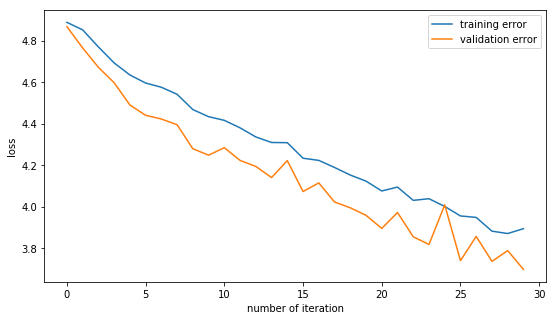

In [40]:
# Plot the loss over epochs for train & validation set.
plt.figure(figsize= (9, 5))
plt.plot(loss['train'], label= 'training error')
plt.plot(loss['valid'], label= 'validation error')
plt.xlabel('number of iteration')
plt.ylabel('loss')
plt.legend()

__NOTE__ here, the graph shows that the network is high bias. One reason could be the high degree of Dropout as regularization, p = .5, perhaps. In any case, making the network more flexible will definitely boost the generalization power of the model.

In [42]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [8]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    loss_test = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test'], start = 1):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        loss_test += 1 / batch_idx * (loss.data - loss_test)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(loss_test))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [44]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.590006


Test Accuracy: 15% (131/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [7]:
# Specify data loaders
dir_images = '/data/dog_images/'

dir_train = os.path.join(dir_images, 'train')
dir_valid = os.path.join(dir_images, 'valid')
dir_test = os.path.join(dir_images, 'test')

# Note: to prevent "TypeError: tensor is not a torch image."
# The ToTensor transform should come before the Normalize transform
transform_dogs = {
    'train': T.Compose([
        T.RandomResizedCrop(224),
        T.RandomRotation(15),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean= [.5] * 3, std= [.25] * 3),
    ]),
    
    'eval': T.Compose([
        # Note: argument to size should be a tuple.
        # Otherwise: RuntimeError: invalid argument 0
        T.Resize(size=(224, 224)),
        T.ToTensor(),
        T.Normalize(mean= [.5] * 3, std= [.25] * 3),
    ])
}


data_train = datasets.ImageFolder(dir_train, transform= transform_dogs['train'])
data_valid = datasets.ImageFolder(dir_valid, transform= transform_dogs['eval'])
data_test = datasets.ImageFolder(dir_test, transform= transform_dogs['eval'])

params_other = {'batch_size': 32, 'num_workers': 0, 'shuffle': True}

loader_train = torch.utils.data.DataLoader(data_train, **params_other)
loader_valid = torch.utils.data.DataLoader(data_valid, **params_other)
loader_test = torch.utils.data.DataLoader(data_test, **params_other)

# Make the loaders a dictionary for convenient usage in the coming functions
loaders_transfer = {'train': loader_train, 'valid': loader_valid, 'test': loader_test}

### Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [10]:
model_transfer = models.resnet18(pretrained= True)
print(model_transfer)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 77464139.72it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [11]:
# Fix the gradients for all the model parameters.
for param in model_transfer.parameters():
    param.requires_grad = False

In [12]:
# Parameters of newly constructed modules have requires_grad=True by default.
num_ftrs = model_transfer.fc.in_features

model_transfer.fc = nn.Linear(num_ftrs, 133)

### Specify Loss Function and Optimizer

In [13]:
# Select loss function
criterion_transfer = nn.CrossEntropyLoss()

# Select the optimizer with the parameters that need optimizing
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr= 0.001, momentum= 0.9)

In [14]:
use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

### Train and Validate the Model

In [17]:
# train the model
model_transfer, loss = train(n_epochs= 7,
                            loaders= loaders_transfer,
                            model= model_transfer,
                            optimizer= optimizer_transfer,
                            criterion= criterion_transfer,
                            use_cuda= use_cuda,
                            save_path= 'model_transfer.pt'
                            )

Epoch: 1 	Training Loss: 3.091848 	Validation Loss: 2.393844
Validation loss decreased (inf --> 2.393844).	Saving model...

Epoch: 2 	Training Loss: 2.697791 	Validation Loss: 2.001905
Validation loss decreased (2.393844 --> 2.001905).	Saving model...

Epoch: 3 	Training Loss: 2.407515 	Validation Loss: 1.747040
Validation loss decreased (2.001905 --> 1.747040).	Saving model...

Epoch: 4 	Training Loss: 2.190333 	Validation Loss: 1.598128
Validation loss decreased (1.747040 --> 1.598128).	Saving model...

Epoch: 5 	Training Loss: 2.026259 	Validation Loss: 1.421807
Validation loss decreased (1.598128 --> 1.421807).	Saving model...

Epoch: 6 	Training Loss: 1.895811 	Validation Loss: 1.331099
Validation loss decreased (1.421807 --> 1.331099).	Saving model...

Epoch: 7 	Training Loss: 1.813735 	Validation Loss: 1.257720
Validation loss decreased (1.331099 --> 1.257720).	Saving model...



### Test the Model

In [18]:
# call test function    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.287164


Test Accuracy: 74% (620/836)


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I didn't want to use VGG because I've already done it for CIFAR10 data. At first I tried to go with `Inception_v3`, but I couldn't figure it out. That's why I switched to `resnet18`. Like other famouse CNN archtectures, including those mentioned before, `resnet18` has been trained on the famouse `ImageNet` data with more than a million images from 1000 different categories. As a result, it has learnt rich feature representation for a variety of tasks.     

As more than 100 of those categories are various dog breeds, it'll be a viable choice for our task. Together with the fact that our dataset is fairly large one, I fixed all the weights except for the last layer which does the classification task.    

My choice of loss function and optimizer are also typical of the classification task. Furthermore, because the network is already trained on massive dataset, I didn't train for large epochs. In fact, at first I tried with only 2 epochs, but I got 48% accuracy. So, to be sure, I went with 7 epochs. 

### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [8]:
# load the saved model.

model = models.resnet18(pretrained= True)
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 133)

loc = 'cpu'
if torch.cuda.is_available():
    loc = lambda storage, loc: storage.cuda()

# if torch.cuda.is_available():
#     map_location=lambda storage, loc: storage.cuda()
# else:
#     map_location='cpu'

model.load_state_dict(torch.load('model_transfer.pt', map_location= loc))
model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 85984070.22it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [9]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
# class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
class_names = [item[4:].replace("_", " ") for item in data_train.classes]

transform_eval = T.Compose([
        T.Resize(size=(224, 224)),
        T.ToTensor(),
        T.Normalize(mean= [.5] * 3, std= [.25] * 3),
    ])

def predict_breed_transfer(img_path):
    """ Takes a path to an image as input
    and returns the dog breed that is predicted by the model.
    """
    img = Image.open(img_path).convert('RGB')
    img = transform_eval(img)
    pred = model(img.unsqueeze(0)).data.max(1, keepdim=True)[1]
    return class_names[pred]

In [41]:
predict_breed_transfer('images/Welsh_springer_spaniel_08203.jpg')

'Welsh springer spaniel'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  


### Write the Algorithm for App

In [42]:
def run_app(img_path):
    """
    Arguments:
    -------------
    img_path {str} path to the image file
    """
    # Read the image.
    img = Image.open(img_path)
    pred = predict_breed_transfer(img_path)
    
    if dog_detector(img_path):
        print(f'Detected a dog from "{pred}" breed.')
    elif face_detector(img_path):
        print(f'Hello human!\nYou look like a: "{pred}".')
    else:
        print('[WARN] Cannot detect neither a dog or a human.')
    plt.imshow(img)


Detected a dog from "Curly-coated retriever" breed.


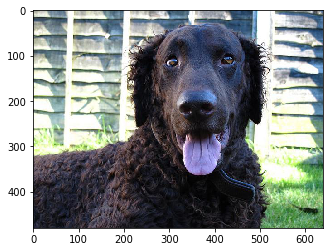

In [43]:
run_app('images/Curly-coated_retriever_03896.jpg')

Hello human!
You look like a: "Brussels griffon".


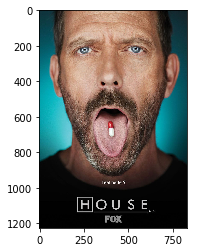

In [44]:
run_app('images/housemd.jpg')

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test the Algorithm on Sample Images!


[WARN] Cannot detect neither a dog or a human.


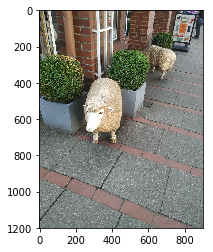

In [45]:
run_app('images/sheepsheep.jpg')

[WARN] Cannot detect neither a dog or a human.


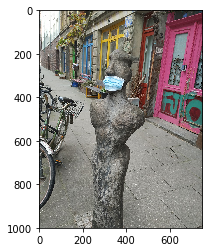

In [46]:
run_app('images/maske.jpg')

Hello human!
You look like a: "Pharaoh hound".


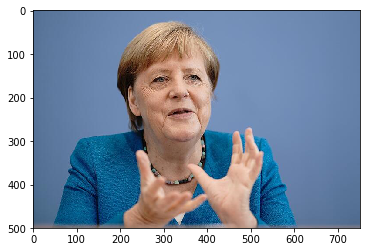

In [47]:
run_app('images/merkel.jpg')

Detected a dog from "Belgian malinois" breed.


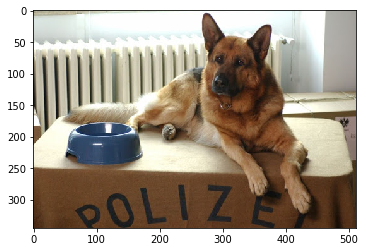

In [48]:
run_app('images/kommissarRex.jpg')

Hello human!
You look like a: "Chinese crested".


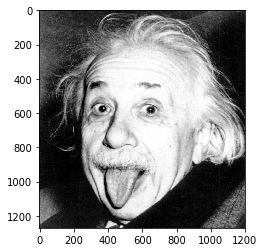

In [49]:
run_app('images/einstein.jpg')

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer__ I believe it meets the expectation. I was surprised that it classified [Kommissar Rex](https://en.wikipedia.org/wiki/Inspector_Rex) as _Belgian malinois_. But doing a bit of research,the look infact similar. 

Ideas to improve the model performance:
1. Run for more epochs.
2. Use data augmentation to boost generalization power of the model.
3. Perhaps other choices of optimization algorithms could help.
4. Also, I gather, not fixing the weight, and fine-tuning the model will boost the performance. Since the dataset is farily large and not so similar, as well as not so different from the original ImageNet dataset. 